In [33]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince



In [34]:
rfm_df = pd.read_csv('datasets/rfm.csv')
rfm_df = rfm_df.iloc[:, 0:4]
rfm_df

,customer_id,recency,frequency,monetary_value
0,00012a2ce6f8dcda20d059ce98491703,293,1,114.74
1,0001fd6190edaaf884bcaf3d49edf079,552,1,195.42
2,0004164d20a9e969af783496f3408652,510,1,71.80
3,00050bf6e01e69d5c0fd612f1bcfb69c,351,1,85.23
4,00066ccbe787a588c52bd5ff404590e3,209,1,270.00
...,...,...,...,...
40278,fff415b4c72e09483a25c15108c65d31,283,1,84.57
40279,fff5169e583fd07fac9fec88962f189d,115,1,152.77
40280,fff89c8ed4fcf69a823c1d149e429a0b,261,1,44.10
40281,fffcb937e9dd47a13f05ecb8290f4d3e,171,1,91.91


In [35]:
rfm_df.describe()

,recency,frequency,monetary_value
count,40283.000000,40283.000000,40283.000000
mean,250.858327,1.048110,179.998926
std,154.752154,0.378627,280.126487
min,1.000000,1.000000,10.070000
25%,126.000000,1.000000,65.745000
50%,230.000000,1.000000,113.620000
75%,361.000000,1.000000,192.850000
max,729.000000,29.000000,13664.080000


In [36]:
# rfm_df.set_index('customer_id')

from sklearn.preprocessing import MinMaxScaler

rfm_df_scaled = rfm_df.copy()
scaler = MinMaxScaler()
rfm_df_scaled.iloc[:, 1:] = scaler.fit_transform(rfm_df.iloc[:, 1:])
rfm_df_scaled

,customer_id,recency,frequency,monetary_value
0,00012a2ce6f8dcda20d059ce98491703,0.401099,0.0,0.007666
1,0001fd6190edaaf884bcaf3d49edf079,0.756868,0.0,0.013575
2,0004164d20a9e969af783496f3408652,0.699176,0.0,0.004521
3,00050bf6e01e69d5c0fd612f1bcfb69c,0.480769,0.0,0.005505
4,00066ccbe787a588c52bd5ff404590e3,0.285714,0.0,0.019037
...,...,...,...,...
40278,fff415b4c72e09483a25c15108c65d31,0.387363,0.0,0.005456
40279,fff5169e583fd07fac9fec88962f189d,0.156593,0.0,0.010451
40280,fff89c8ed4fcf69a823c1d149e429a0b,0.357143,0.0,0.002492
40281,fffcb937e9dd47a13f05ecb8290f4d3e,0.233516,0.0,0.005994


In [37]:
from sklearn.pipeline import Pipeline

# https://github.com/yzhao062/pyod
clf = ECOD()

clf.fit(rfm_df_scaled.iloc[:, 1:])
outliers = clf.predict(rfm_df_scaled.iloc[:, 1:])

rfm_df_scaled['outlier'] = outliers
rfm_df['outlier'] = outliers

rfm_scaled_no_outliers = rfm_df_scaled[rfm_df_scaled['outlier'] == 0]
rfm_scaled_no_outliers = rfm_scaled_no_outliers.drop('outlier', axis=1)

rfm_scaled_no_outliers

,customer_id,recency,frequency,monetary_value
0,00012a2ce6f8dcda20d059ce98491703,0.401099,0.0,0.007666
1,0001fd6190edaaf884bcaf3d49edf079,0.756868,0.0,0.013575
2,0004164d20a9e969af783496f3408652,0.699176,0.0,0.004521
3,00050bf6e01e69d5c0fd612f1bcfb69c,0.480769,0.0,0.005505
4,00066ccbe787a588c52bd5ff404590e3,0.285714,0.0,0.019037
...,...,...,...,...
40278,fff415b4c72e09483a25c15108c65d31,0.387363,0.0,0.005456
40279,fff5169e583fd07fac9fec88962f189d,0.156593,0.0,0.010451
40280,fff89c8ed4fcf69a823c1d149e429a0b,0.357143,0.0,0.002492
40281,fffcb937e9dd47a13f05ecb8290f4d3e,0.233516,0.0,0.005994


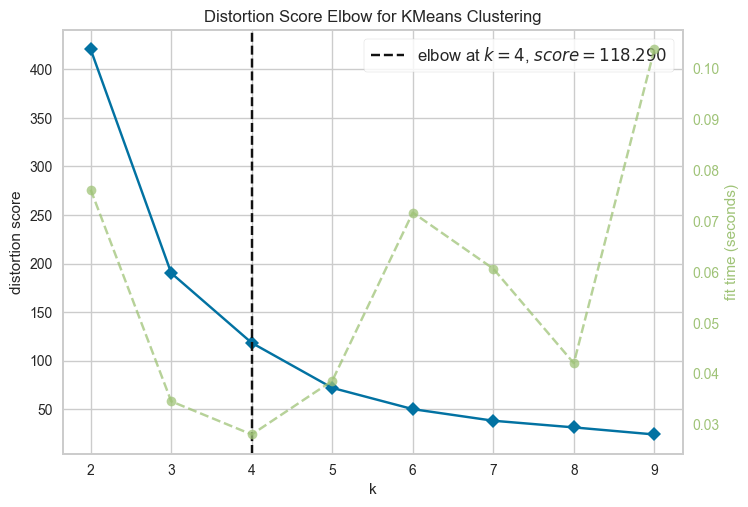

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
kmeans = KMeans(init='k-means++', random_state=0, n_init='auto')

visualizer = KElbowVisualizer(kmeans, k=(2,10))
visualizer.fit(rfm_scaled_no_outliers.iloc[:, 1:])
visualizer.show()

In [39]:
# def make_Silhouette_plot(X, n_clusters):
#     plt.xlim([-0.1, 1])
#     plt.ylim([0, len(X) + (n_clusters + 1) * 10])
#     clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
#     cluster_labels = clusterer.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print(
#         "For n_clusters =", n_clusters,
#         "The average silhouette_score is :", silhouette_avg,
#     )
# # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)
#     y_lower = 10
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#         ith_cluster_silhouette_values.sort()
#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
#         color = cm.nipy_spectral(float(i) / n_clusters)
#         plt.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )
#         plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#         y_lower = y_upper + 10
#         plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
#         plt.xlabel("The silhouette coefficient values", fontsize=24)
#         plt.ylabel("Cluster label", fontsize=24)
#         plt.axvline(x=silhouette_avg, color="red", linestyle="--")
#         plt.yticks([])  
#         plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
# range_n_clusters = list(range(2,10))
# for n_clusters in range_n_clusters:
#     print(f"N cluster: {n_clusters}")
#     make_Silhouette_plot(rfm_scaled_no_outliers.iloc[:, 1:], n_clusters)   
#     plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
#     plt.close()

In [40]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
clusters_predict = km.fit_predict(rfm_scaled_no_outliers.iloc[:, 1:])
print(km.inertia_)

111.10597699194079


In [41]:
np.unique(clusters_predict)

array([0, 1, 2, 3])

In [42]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(rfm_scaled_no_outliers.iloc[:, 1:],clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(rfm_scaled_no_outliers.iloc[:, 1:],clusters_predict)}")

"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(rfm_scaled_no_outliers.iloc[:, 1:],clusters_predict)}")

Davies bouldin score: 0.5317161072183076
Calinski Score: 140189.32239928702


Silhouette Score: 0.5451320080236522


In [43]:
rfm_scaled_no_outliers

,customer_id,recency,frequency,monetary_value
0,00012a2ce6f8dcda20d059ce98491703,0.401099,0.0,0.007666
1,0001fd6190edaaf884bcaf3d49edf079,0.756868,0.0,0.013575
2,0004164d20a9e969af783496f3408652,0.699176,0.0,0.004521
3,00050bf6e01e69d5c0fd612f1bcfb69c,0.480769,0.0,0.005505
4,00066ccbe787a588c52bd5ff404590e3,0.285714,0.0,0.019037
...,...,...,...,...
40278,fff415b4c72e09483a25c15108c65d31,0.387363,0.0,0.005456
40279,fff5169e583fd07fac9fec88962f189d,0.156593,0.0,0.010451
40280,fff89c8ed4fcf69a823c1d149e429a0b,0.357143,0.0,0.002492
40281,fffcb937e9dd47a13f05ecb8290f4d3e,0.233516,0.0,0.005994


In [44]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()

    fig = px.scatter_3d(df, 
                        x=columns[0], 
                        y=columns[1], 
                        z=columns[2],
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()


    fig = px.scatter(df, 
                        x=columns[0], 
                        y=columns[1],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


In [45]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=42)
clusters_predict = km.fit_predict(rfm_scaled_no_outliers.iloc[:, 1:])
print(km.inertia_)

190.17063245147776


In [46]:
rfm_scaled_no_outliers

,customer_id,recency,frequency,monetary_value
0,00012a2ce6f8dcda20d059ce98491703,0.401099,0.0,0.007666
1,0001fd6190edaaf884bcaf3d49edf079,0.756868,0.0,0.013575
2,0004164d20a9e969af783496f3408652,0.699176,0.0,0.004521
3,00050bf6e01e69d5c0fd612f1bcfb69c,0.480769,0.0,0.005505
4,00066ccbe787a588c52bd5ff404590e3,0.285714,0.0,0.019037
...,...,...,...,...
40278,fff415b4c72e09483a25c15108c65d31,0.387363,0.0,0.005456
40279,fff5169e583fd07fac9fec88962f189d,0.156593,0.0,0.010451
40280,fff89c8ed4fcf69a823c1d149e429a0b,0.357143,0.0,0.002492
40281,fffcb937e9dd47a13f05ecb8290f4d3e,0.233516,0.0,0.005994


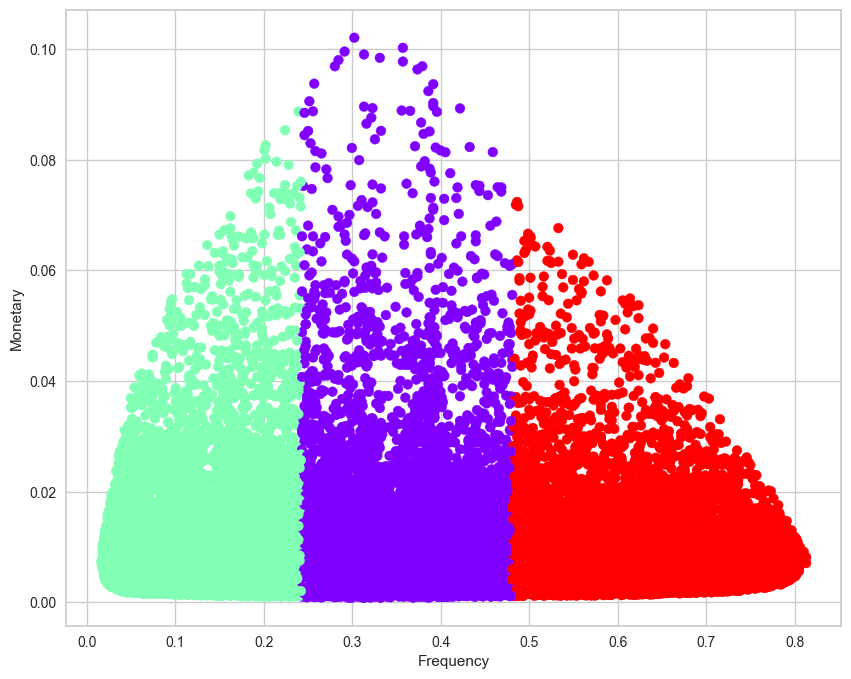

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(rfm_scaled_no_outliers.iloc[:, 1], rfm_scaled_no_outliers.iloc[:, 3], c=clusters_predict, cmap='rainbow')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [48]:
pca_3d_object, df_pca_3d = get_pca_3d(rfm_scaled_no_outliers.iloc[:, 1:], clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              1.021        34.04%                     34.04%
1              1.003        33.45%                     67.48%
2              0.975        32.52%                    100.00%


In [18]:
# calculate silhouette score 
silhouette_avg = silhouette_score(rfm_scaled_no_outliers.iloc[:, 1:], clusters_predict)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.9202107613633588


In [17]:
# plot the clusters in 3d using scikit-learn
from sklearn.calibration import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(rfm_scaled_no_outliers.iloc[:, 1:], clusters_predict)

rfm_scaled_no_outliers['cluster'] = clusters_predict
rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].astype('category')
rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].cat.rename_categories(['cluster_1', 'cluster_2', 'cluster_3'])

# convert categorical variable to numerical
le = LabelEncoder()
rfm_scaled_no_outliers['cluster'] = le.fit_transform(rfm_scaled_no_outliers['cluster'])
rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].cat.codes

# plot it
fig = px.scatter_3d(rfm_scaled_no_outliers, 
                        x='recency', 
                        y='frequency', 
                        z='monetary_value',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title="title").update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": 0.8,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": 0.1,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
fig.show()




AttributeError: Can only use .cat accessor with a 'category' dtype

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9642
[LightGBM] [Info] Number of data points in the train set: 88798, number of used features: 4
[LightGBM] [Info] Start training from score -1.407670
[LightGBM] [Info] Start training from score -0.993865
[LightGBM] [Info] Start training from score -0.954138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

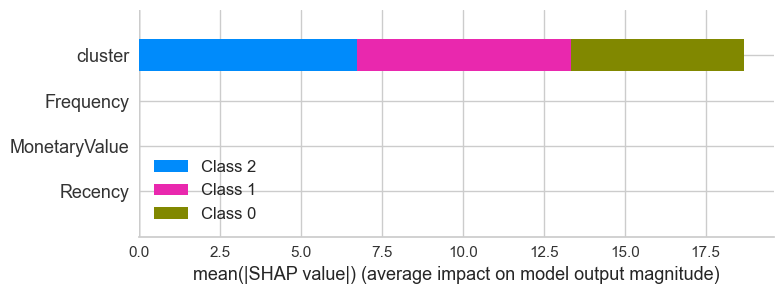

In [131]:
from cv2 import exp
import lightgbm as lgb
from numpy import shape
import shap

clf_km = lgb.LGBMClassifier()

for col in rfm_scaled_no_outliers.columns[1:]:
    rfm_scaled_no_outliers[col] = rfm_scaled_no_outliers[col].astype('category')
    
clf_km.fit(rfm_scaled_no_outliers.iloc[:, 1:], clusters_predict)

explainer = shap.TreeExplainer(clf_km)
shape_values = explainer.shap_values(rfm_scaled_no_outliers.iloc[:, 1:])
shap.summary_plot(shape_values, rfm_scaled_no_outliers.iloc[:, 1:], plot_type="bar")